In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Application dataset
application_train dataset has:
* 307511 observations and 122 features
* No duplicates
* Groups of features have Null values

In [73]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')
help_tool.first_look(application_train)

Dataset has 307511 observations and 122 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
TARGET,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
CODE_GENDER,object,0,0.0
FLAG_OWN_CAR,object,0,0.0
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_WEEK,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,float64,41519,13.5


In [74]:
application_train.drop(columns=['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START'], inplace=True)

### Cleaning object features
Before feature selection for Target, object type columns must be handeled. OneHotEncoding is a not good aproach (the dataset has 16 object type features), which would result of column number explosion an would confuse the Light XGB model when fitting for feature importance.

In [75]:
application_train = help_tool.convert_flags(application_train)

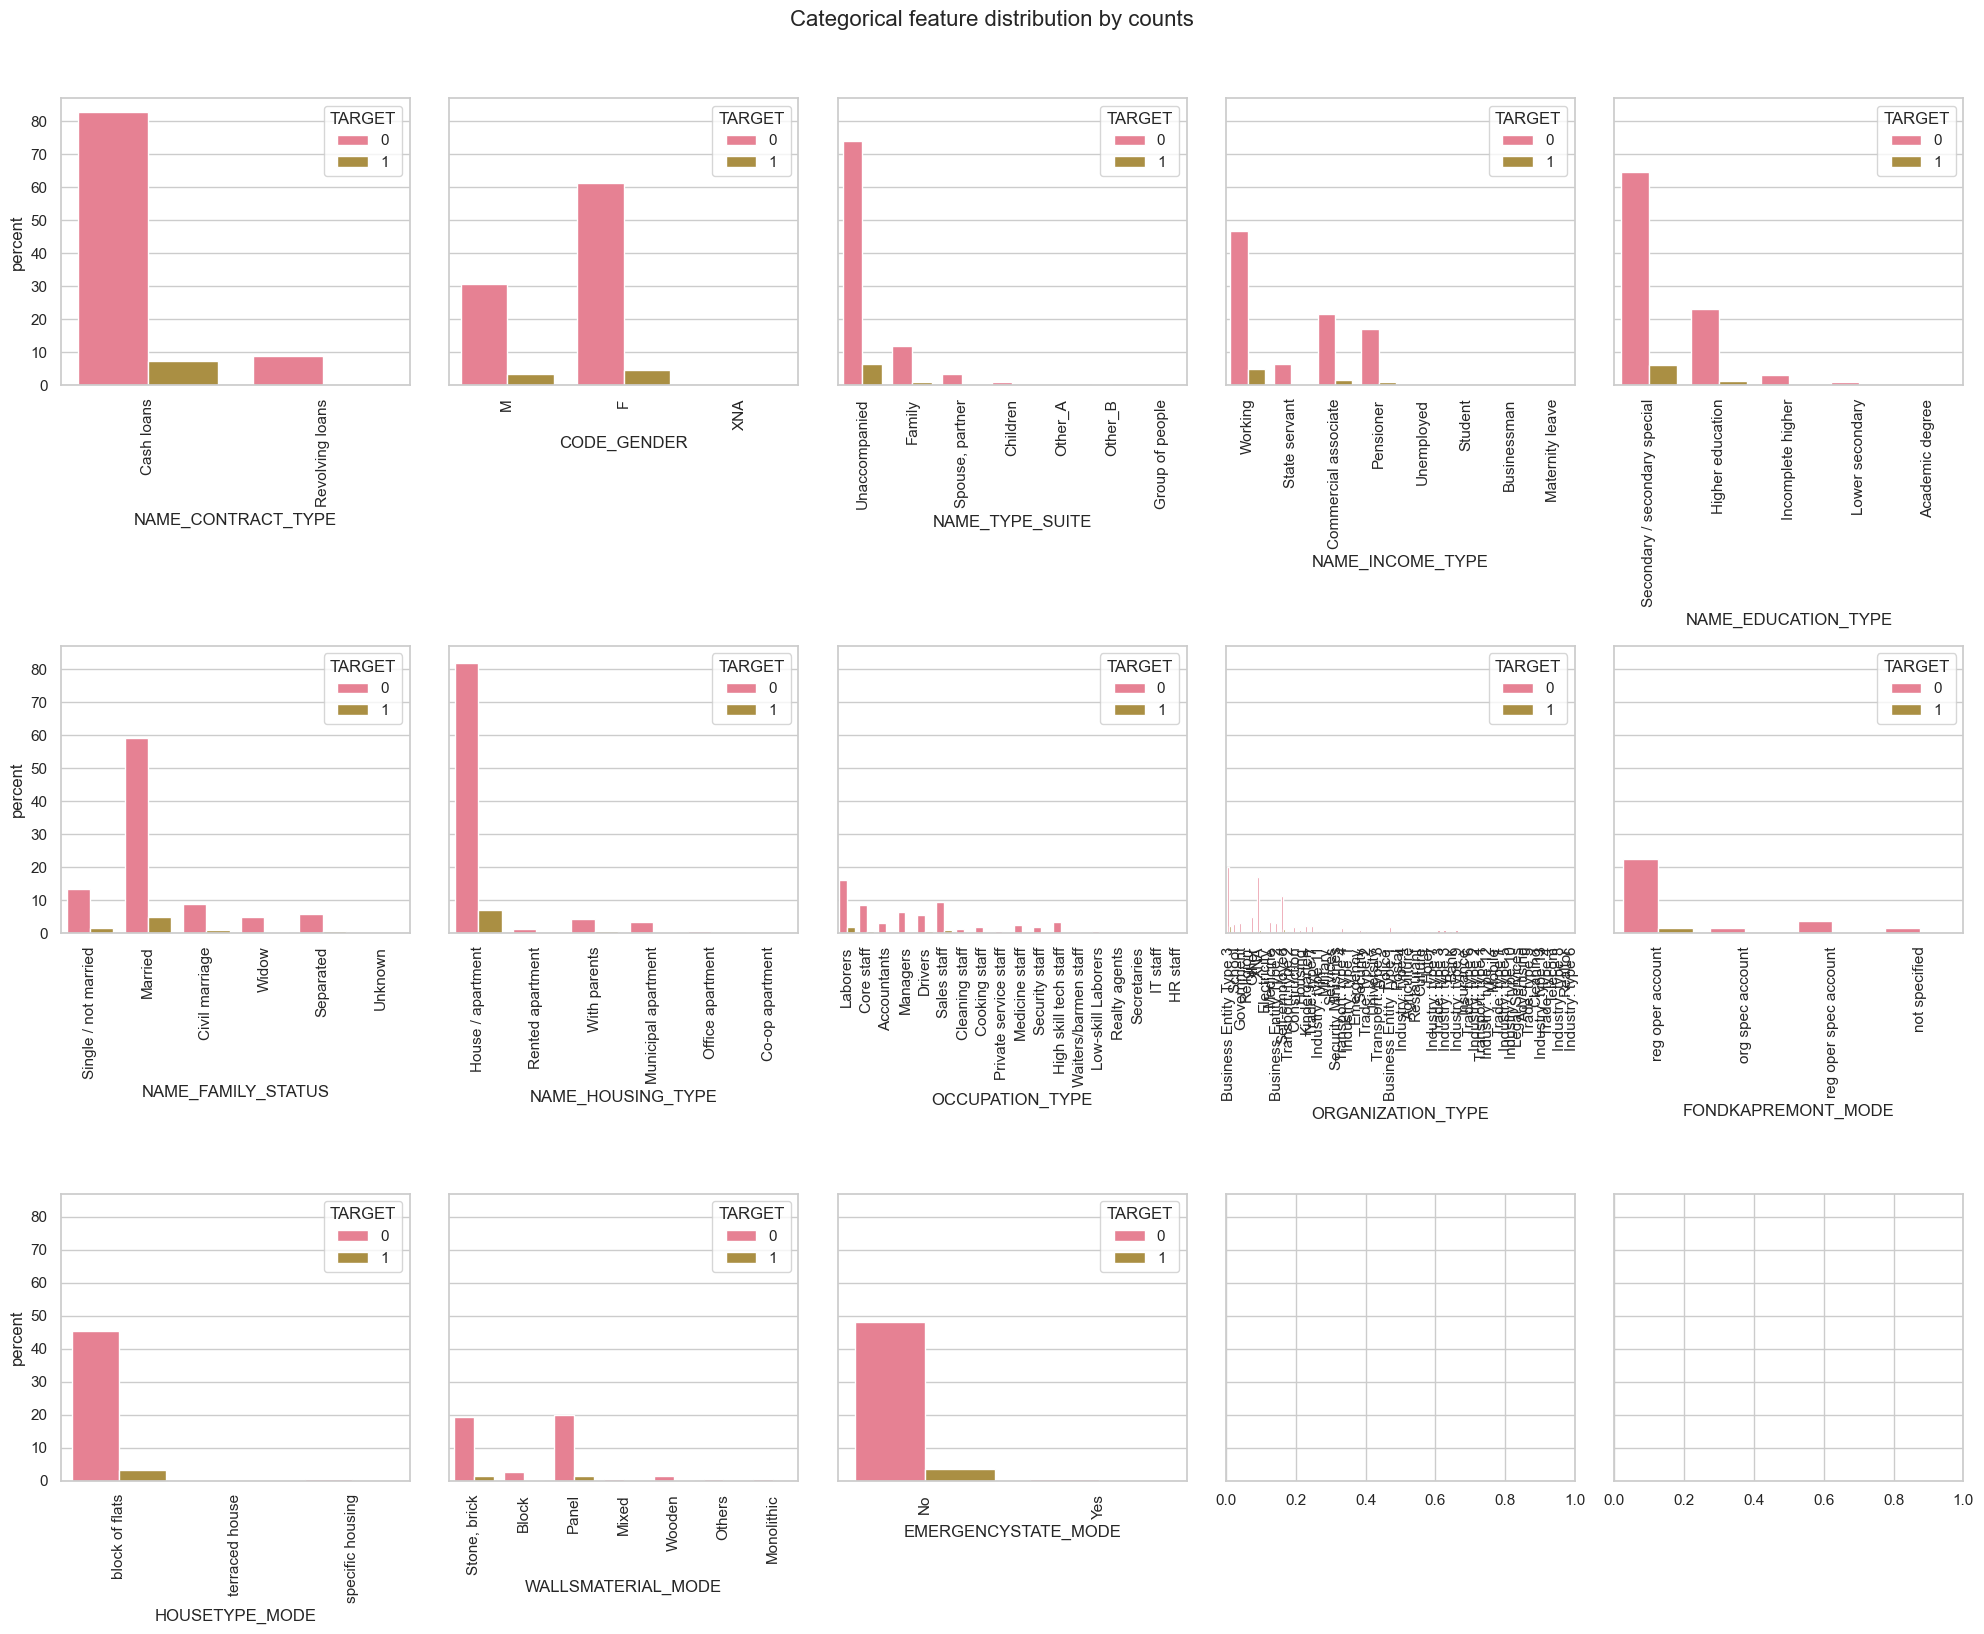

In [76]:
object_columns = application_train.select_dtypes(include=['object']).columns.tolist()

fig, axes = plt.subplots(3, 5, figsize=(20, 16), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.countplot(data=application_train, x=col, 
                 ax=axes[i],  
                 legend=True,
                 stat="percent",
                 hue='TARGET'
                 )
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

From the above plots, it is seen thecre's no object feature with a clear dependency on Target. Thus, feature will be:
* Numerically encoded when posible (Cash Loans / not Cash Loans)
* Dropping discriminatory features, which use could be prohibited by Bank Associantions (i.e. gender)
* Discrimination could be avoided by categorizing NAME_FAMILY_STATUS to single/not single.
* Education type can be numerically encoded.
* Grouped to subgroups if feature has high Cardinality (number of unique value)

Additionly, some features might be prohibited by the Banking Authorities, i.e. Gender identity, Skin Colour, Religion. For this reason, GENDER_CODE will be dropped, despite having a potential inpact on TARGET.

Null Hypothesis (H0): There is no relationship between 'CODE_GENDER' and 'TARGET'. <br>
Alternative Hypothesis (H1): There is a relationship between 'CODE_GENDER' and 'TARGET'.

In [77]:
help_stats.chi_squared_test(application_train.dropna(subset='CODE_GENDER'), ('TARGET', 'CODE_GENDER'))

Chi-squared statistic: 920.7913340361749. P-value: 1.1290217848908289e-200. Reject the null hypothesis.


Conclussion: CODE_GENDER has an impact on TARGET, but due to potential discriminatory reglaments, it will be removed.

In [78]:
application_train = help_tool.encode_categories(application_train)

Target is imbalanced, as only 8 % of clients default.

In [79]:
application_train['TARGET'].value_counts() / application_train['TARGET'].count() * 100

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

# Feature Selection
## Variance 
A lot of features have 0 or less than 0.1 variance. One of the zero variance features is TARGET. Since the dataset is imbalanced, dropping Zero variance features could result in lost information for the minority TARGET.

In [80]:
help_model.zero_variance_features(application_train)

['TARGET',
 'REGION_POPULATION_RELATIVE',
 'FLAG_MOBIL',
 'FLAG_CONT_MOBILE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI'

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

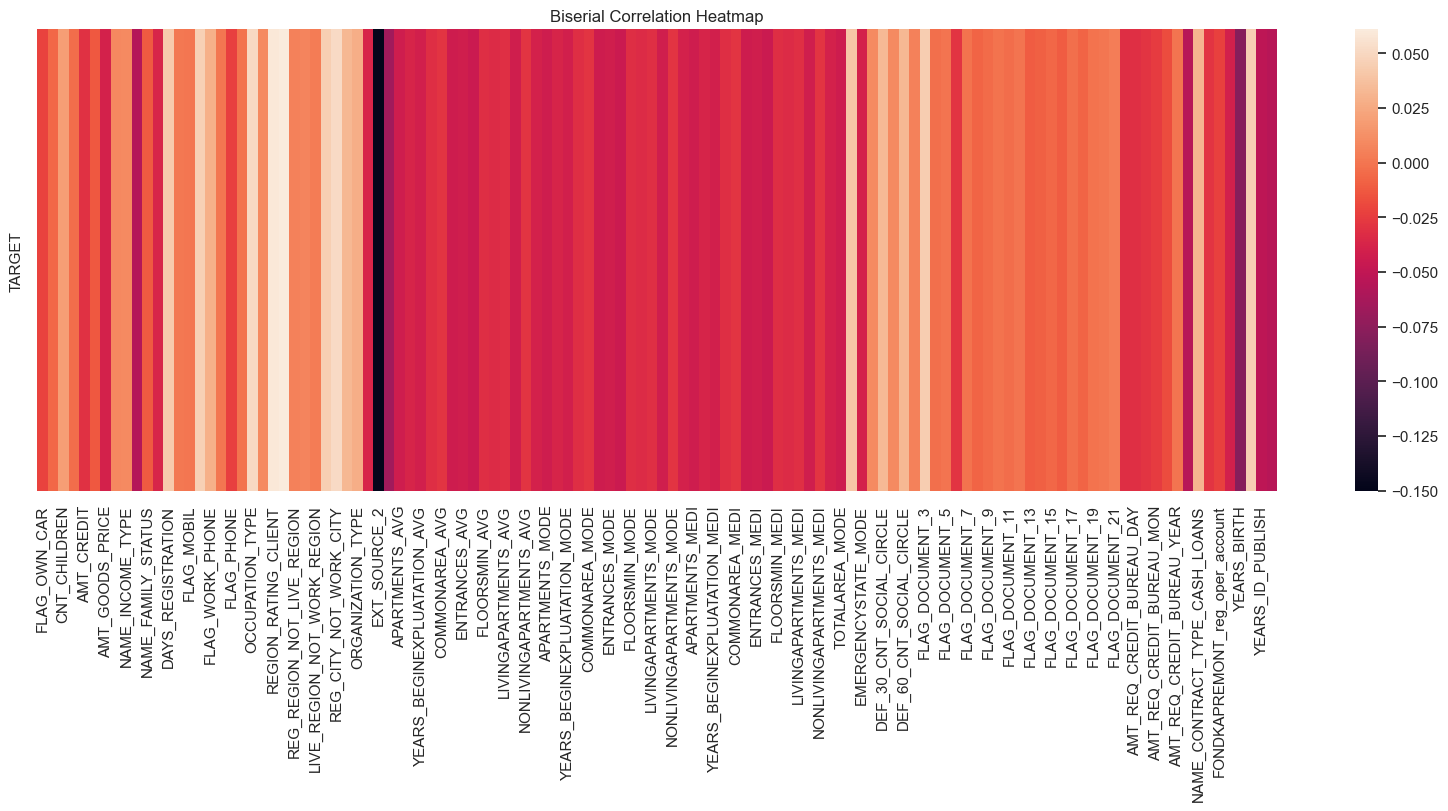

In [81]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(application_train.fillna(-1), application_train.drop(columns=['SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

## Adding previously created features

In [82]:
sub_data_clusters = help_tool.csv_download(r'Archive\home-credit-default-risk\sub_data_clusters.csv').drop(columns='Unnamed: 0')
bureau_data_clusters = help_tool.csv_download(r'Archive\home-credit-default-risk\sorted_bureau_feature_matrix.csv')[['SK_ID_CURR', 'Cluster_bureau']]

In [83]:
whole_data = duckdb.query("""
             SELECT 
                A.*, 
                B.*, 
                C.Cluster_bureau

             FROM application_train A
             LEFT JOIN sub_data_clusters B
             ON A.SK_ID_CURR = B.SK_ID_CURR
             LEFT JOIN bureau_data_clusters C
             ON A.SK_ID_CURR = C.SK_ID_CURR
             
             """).to_df().drop(columns='SK_ID_CURR_1')

In [84]:
whole_data['EXT_SOURCE_1'].isna().sum()

173378

## TRAGET

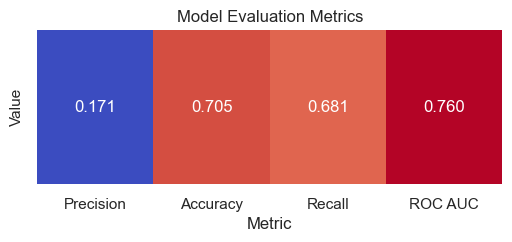

In [85]:
target_feature_importance = help_model.model_feature_importance_target(whole_data)

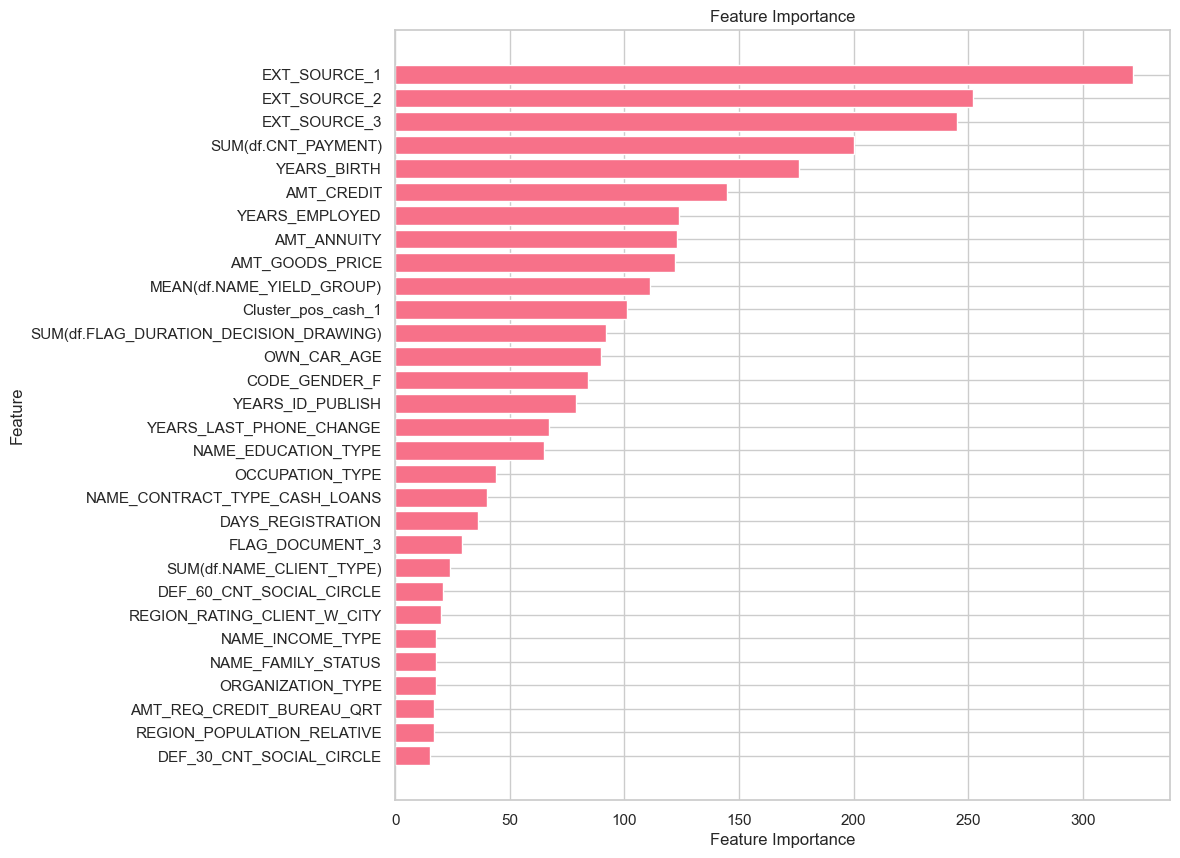

In [86]:
help_model.plot_feature_importance(target_feature_importance.head(30))

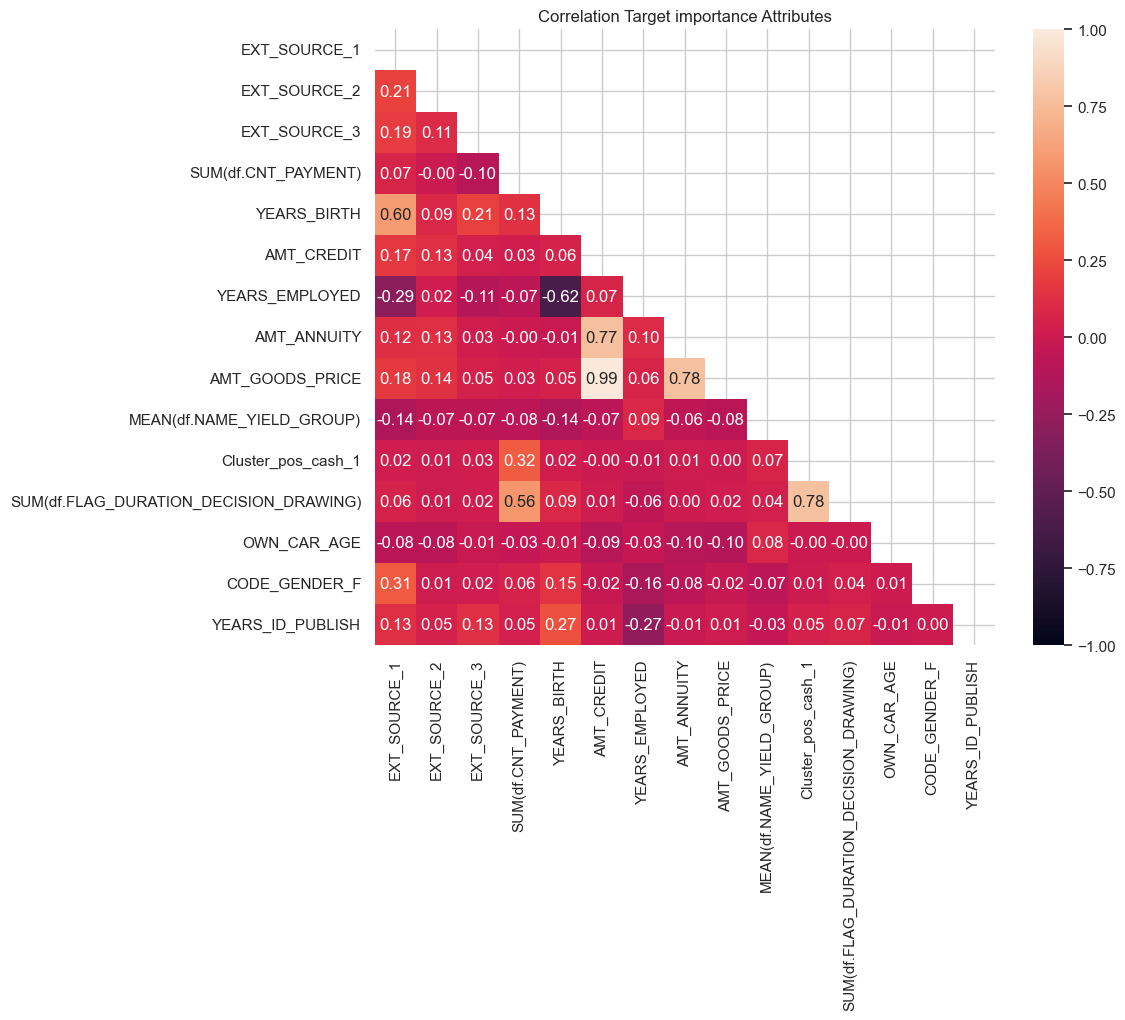

In [87]:
help_visuals.heatmap(whole_data[target_feature_importance['feature'].head(15).to_list()], 'TARGET importance', 'pearson')

In [88]:
target_features = whole_data[target_feature_importance['feature'].head(15).to_list()].drop(columns=['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'SUM(df.FLAG_DURATION_DECISION_DRAWING)']).columns.to_list()
target_features

['EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'SUM(df.CNT_PAYMENT)',
 'YEARS_BIRTH',
 'AMT_CREDIT',
 'YEARS_EMPLOYED',
 'MEAN(df.NAME_YIELD_GROUP)',
 'Cluster_pos_cash_1',
 'OWN_CAR_AGE',
 'CODE_GENDER_F',
 'YEARS_ID_PUBLISH']

## EXT_SOURCE_1

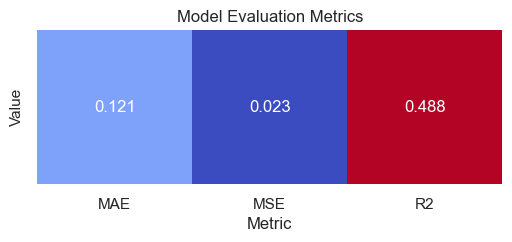

In [89]:
ext_source_1_feature_importance = help_model.model_feature_importance_exteranal(whole_data)

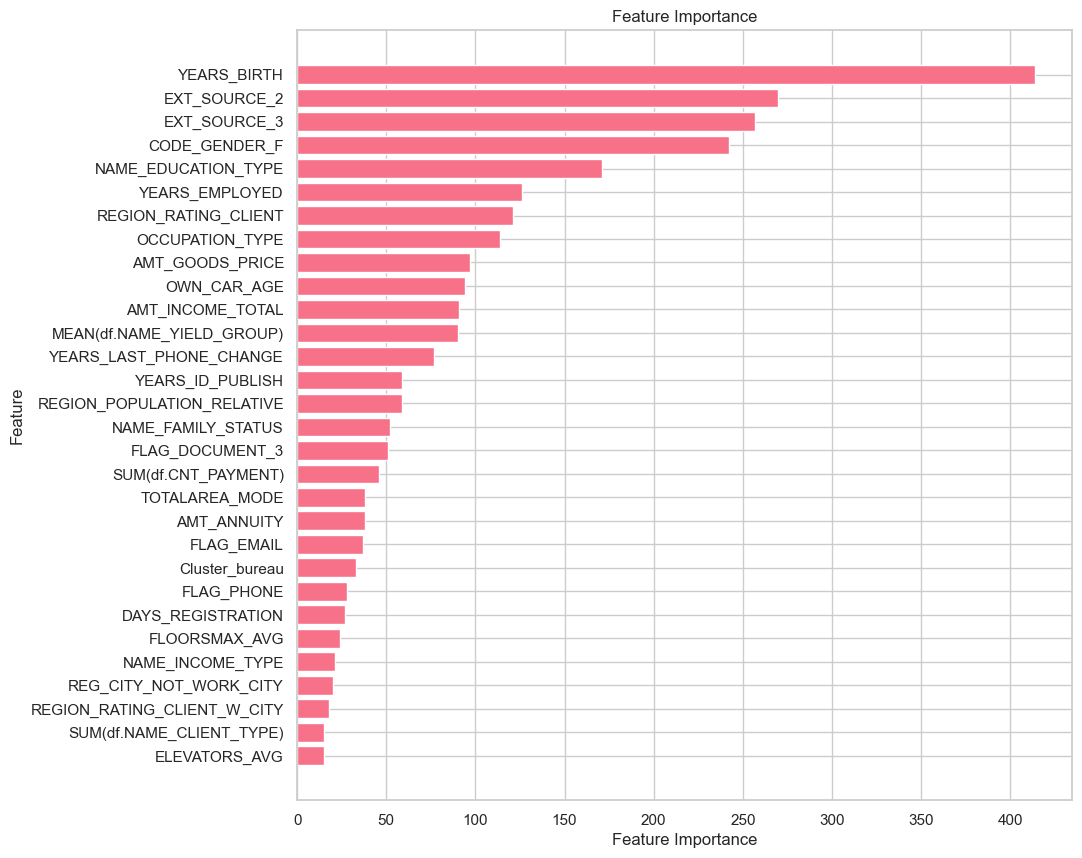

In [90]:
help_model.plot_feature_importance(ext_source_1_feature_importance.head(30))

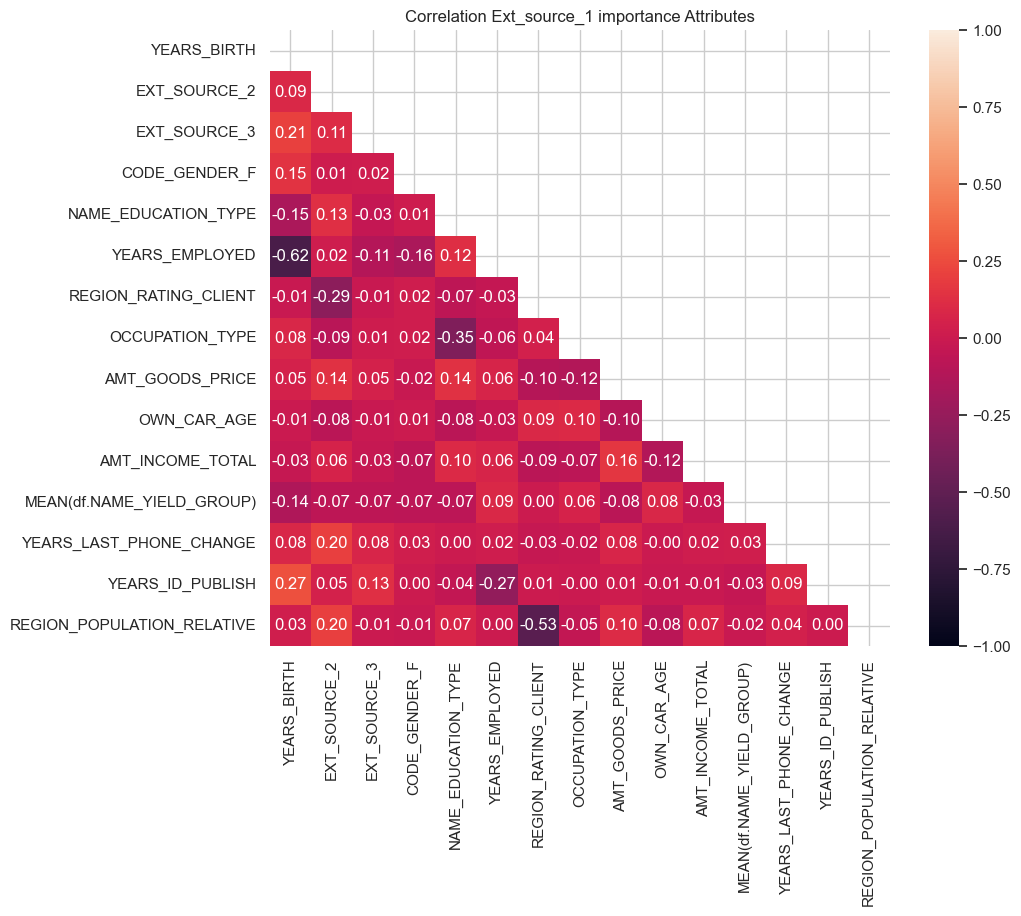

In [91]:
help_visuals.heatmap(whole_data[ext_source_1_feature_importance['feature'].head(15).to_list()], 'EXT_SOURCE_1 importance', 'pearson')

In [92]:
ext_source_1_features = whole_data[ext_source_1_feature_importance['feature'].head(15).to_list()].columns.to_list()

In [93]:
selected_features = list(set(target_features + ext_source_1_features)) + ['TARGET']

selected_data = whole_data[selected_features].rename(columns={'MEAN(df.NAME_YIELD_GROUP)': 'AVG_Risk_Score'})

selected_data.to_csv(r'Archive\home-credit-default-risk\selected_data.csv')